# PEC1 - Generative Adversarial Networks
A partir del conjunto de datos CIFAR10, se debe entrenar una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se deberá agregar *experience replay* y comparar los resultados con los obtenidos en la red inicial. Por último, se deberá convertir la red en una GAN condicional. 

## Instrucciones
Se debe contestar a cada apartado de la práctica en el espacio correspondiente de esta plantilla. Los apartados que se deben contestar en lenguaje natural (utilizando las celdas de tipo Markdown), se han resaltado en amarillo. Se debe añadir debajo del texto resaltado la respuesta correspondiente. Cuando el texto subrayado indique algún requisito de la respuesta (por ejemplo en cuanto a longitud de la respuesta), será imprescindible ajustarse a dicho requisito. Los apartados que requieren código en Python deberán contestarse en los espacios de código previstos para ello. Al igual que las respuestas en celdas de tipo markdown, las respuestas de código pueden tener asociados requisitos especiales. Estos espacios se delimitan con la siguiente estructura:
``` python
# INICIO_RESPUESTA
# Requisitos: Elabore una función que siempre devuelva True

def mi_funcion() :
    return True

# FIN_RESPUESTA
```

## Esquema de la plantilla
El esquema de la memoria deberá ser el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos) 
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Sun Jun 29 22:10:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              3W /   65W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [3]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

Es importante saber que para poder depurar algunos métodos como «fit» debemos cambiar el modo de ejecución. Para ello podemos dar el valor «True» al parámetro «run_eagerly» cuando compilemos el modelo. Cuidado, al cambiar este parámetro la ejecución del código será mucho más lenta. Para más información y consejos de depuración se recomienda utilizar los consejos que se indican en la propia página de Keras (https://keras.io/examples/keras_recipes/debugging_tips/)

## Memoria
**Nombre:** <mark>Nombre</mark> Ricardo José Casado Gómez

**Correo UNED:** <mark>nombre@alumno.uned.es</mark> rcasado119@alumno.uned.es

### ¿Qué es una DCGAN?
<mark>\[Respuesta: Explicar lo que es una DCGAN, extensión aproximada de 2 párrafos (200 palabras) \]</mark>


DCGAN es un tipo concreto de network GAN donde las capas van a ser convolucionales. La idea es mezclar los datos reales con los generados por el generator para entregárselos al discriminador para que clasifique entre real o falso el dato seleccionado.


### CIFAR10
<mark>\[Respuesta: Describir brevemente el conjunto de datos CIFAR10, puede utilizar celdas de código para apoyarse en la descripción\]</mark>


El dataset CIFAR-10 tiene 60000 imagenes de 32x32 y divididos en 10 clases distintas sin solapamientos. Luego, hay 6000 imágenes por clases. El número imágenes de entrenamiento y test son 50000 y 1000.

El dataset es dividido en 5 batches (lotes) de entrenamiento y uno para el test. Algo lógico puesto que el dataset de entrenamiento es mayor que el de test.
Cada batch de entrenamiento poseee 5000 imágenes por clase.

Página Web oficial del dataset CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [5]:
# INICIO_RESPUESTA 0/7
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
semilla_aleatoria = 71
# FIN_RESPUESTA

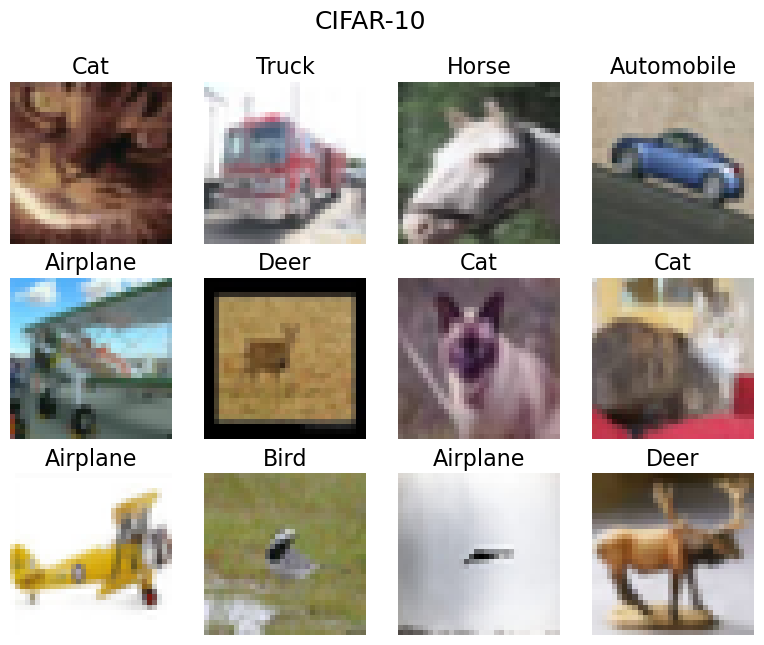

In [8]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1   #Actúa como variable auxiliar 
#En bucle eliges aleatoriamente 12 valores (imagenes) en \[0, X_train]
for n in np.random.randint(low=0,high=len(X_train),size=12): 
    plt.subplot(3, 4, pos) #generas una malla de 12 elementos. Pos es el argumento index
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16) #selecciona el nombre de la clase situada en la posicion n
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>\[Respuesta: Describir los pasos de preprocesado que se han realizado así como la justificación de los mismos (tener en cuenta que se utilizará la función de activación tangencial hipèrbólica)\]</mark>



El objetivo en cualquier función de activación que trabjemos, como la tangente hiperbólica, es evitar el problema de vanishing gradient. Para ello, buscamos manipular el dominio de la función tanh, es decir, sus entradas.\
Recordamos que la función de la tangente hiperbólica y su derivada es 
    $$tanh(x)=\frac{e^{x} - e^{-x}}{ e^{x} + e^{-x} }, \quad tanh^{'}(x)= 1 - tanh^{2}(x) $$
Para evitar el problema hemos de intentar evitar aquellos valores de entradas que puedan hacer que la derivada se anule.\
Como $x\rightarrow -\infty \Rightarrow tanh(x) \rightarrow -1 \Rightarrow tanh^{'}(x) \rightarrow 0 $ y $x\rightarrow \infty \Rightarrow tanh(x) \rightarrow 1 \Rightarrow tanh^{'}(x) \rightarrow 0 $, es importante evitar que los valores estén proximos a la evaluación de estos límites, es decir, en los entornos de los puntos de acumulación $-\infty$ e $\infty$ de la función.

Una manera de conseguirlo es hacer que los valores del dominio estén en $x\in[-1,1]$. Veamos como hacerlo.\
Aunque no este el bloque de código en el jupyter notebook, comprobé que los datos del dataset de Cifar-10 eran de tipo uint8. El número máximo de valores es 255 y además enteros. Puesto que queremos dividir por 255 cada número es necesario convertilo a tipo float32, de lo contrario tendríamos problemas.

De esta manera, tenemos ahora el dominio de la función de la manera $x\in [0,1]$, pero al ser simétrica nos conviene mejor que este centrada en el valor $0$ porque nos permite tener gradientes con valores negativos y positivos.\
Por este mótivo multiplicamos por 2 el intervalo y restamos 1, $x\in [-1, 1]$.



In [10]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])    
all_labels = np.concatenate([Y_train, Y_test])   


# INICIO_RESPUESTA 1/7  
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.

#Aunque no esta en la PEC he ejecuto un código para ver el tipo de dato original del CIFAR-10. Es uint8, por lo que solo guarda 255 valores
#enteros. Hay que usar el método .astype() para usar float32.

all_imgs=all_imgs.astype('float32') / 255.0 
all_imgs=all_imgs*2.0 -1.0

# FIN_RESPUESTA  



In [11]:
#BORRAR
all_imgs

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921573,  0.03529418, -0.15294117],
         [ 0.19215691, -0.01960784, -0.19999999],
         [ 0.16078436, -0.02745098, -0.19215685]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.3098039 , -0.5686275 ],
         [-0.06666666, -0.3490196 , -0.60784316],
         [-0.04313725, -0.31764704, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.0745098 , -0.34117645, -0.60784316],
         [-0.05882353, -0.34117645, -0.60784316],
         [-0.14509803, -0.42745095, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333337, -0

In [12]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

-1.0
-0.052200183
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>\[Respuesta: Describir las recomendaciones que se presentan en el capítulo 17 del libro. Si, tras la evaluación de estas recomendaciones se detectan inconsistencias o no se siguen todas, indicar por qué.\]</mark>



En mitad del capitulo 17 aparece un guidelines que recopilas las recomendaciones a la hora de tratar Deep Convolutional GANs.
1. Reemplazar cualquier capa de agrupación  que tenga convoluciones con pasos en el discrimandor y convoluciones transpuestas en el generador.
2. Usar un batch de normalización tanto en generador y discriminador. A excepción de la capa de salida del generador y la capa de entrada del discriminador.
3. Eliminar todas las capas ocultas conectadas de la arquitecrtura profunda.
4. Usar una función de activación RELU en el generador para todos las capas excepto la capa de salida, la cual debería usar tanh.
5. Usar leaky activation ReLU  en el discriminador para todas las capas.

**Nota**: Algo importante que no aprendí hasta llegar a esta sección es que el hiperparámetro strides en una capa de convolución 2D indica el desplazamiento de la ventana sobre los pixeles $n\times m$ con $n,m\in\mathbb{N}$ y la salida es la entrada divida por el valor de strides. En cambio, cuando usas una convolución transpuesta 2D strides indica cuanto aumentas el tensor de entrada.\
Esa distinción de strides entre estas dos layers no lo tuve en cuenta hasta llegar aquí en la prática. Me abrió los ojos y entendí mejor todo.

Resumiendo: \
Cuando usas <span style="background-color: #4d4d4d">Conv2D</span> reduces la salida\
Cuando usas <span style="background-color: #4d4d4d">Conv2DTranspose</span> aumentas la salida 


#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128 
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')

Todas las capas convolucionales transpuestas tienen una función de activación Leaky ReLU (únicamente las transpuestas) y, tras cada capa se aplicará normalización por lotes (BatchNormalization).

In [13]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(100,)),  

# INICIO_RESPUESTA 2/
# Requisitos: Añada las capas indicadas para el generador      
keras.layers.Dense( 8*8*128 ), #numero de neuronas 
keras.layers.Reshape( [8,8,128] ),
keras.layers.BatchNormalization(),

keras.layers.Conv2DTranspose( 64, kernel_size=4, strides=2, padding="same"  ), # no es obligatorio poner función de activación
keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"   ),
keras.layers.Conv2D( 3 , kernel_size=3 , strides=1, padding='same', activation='tanh')
#Importante, el generador genera muestras que se mezclan con las reales para que el discriminador actúe sobre ellas. Por tanto,
#la dimension de la ultima capa de generator ha de ser igual a la diemnsion d ela entrada de discriminator
#(64, 64, 3)   (alto, ancho, )

# FIN_RESPUESTA 
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       131136    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       65600     
 ranspose)                                                       
                                                        

#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [14]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA 3/7
# Requisitos: Añada las capas indicadas para el discriminador

    keras.layers.Input(shape=(32, 32, 3)),  # Imagen RGB generada   
 
    # Grupo 1   
    keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same'), 
    keras.layers.LeakyReLU(alpha=0.2), # alpha nos dice la magnitud del gradiente para valores negativos
    keras.layers.BatchNormalization(), 
    keras.layers.Dropout(0.3),  # apagamos aleatoriamente un % de neuronas. Evita overfitting

    # Grupo 2 
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same'), 
    keras.layers.LeakyReLU(alpha=0.2), 
    keras.layers.BatchNormalization(), 
    keras.layers.Dropout(0.3),  
    
    # Grupo 3  
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),  
    keras.layers.LeakyReLU(alpha=0.2),  

    # Grupo 4  
    keras.layers.Flatten(),  
    keras.layers.Dense(1, activation='sigmoid')  # Como clasifica, ha der ser binaria es o no es falsa/verdadera  


# FIN_RESPUESTA 
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                      

#### Modelo
<mark>\[Respuesta: Explicar los pasos de entrenamiento de una GAN, diferenciando el proceso de entrenamiento del generador y del discriminador. \]</mark>

Una GAN (Generative Adversarial Network) tiene tres etapas.
1.  En la primera interviene únicamente el generador cuyo objetivo es generar datos sinéticos de manera aleatoria. Estos quedan almacenados en un vector de variables latentes que sera usado por el generador.
2. En la segunda intervienen los datos del dataset original y del generador donde se mezclan ambos. La idea es generar una muestra donde haya un porcentaje de datos originales y sintéticos para presentarlo al discriminador. 
3. En el tercero y último, el discriminador intentando discernir qué datos son o no falsos.  

La función objetivo de la GAN es una función cross entropía binaria. Su expresión es la siguiente:

Sea $y \in \{0, 1\}$ la etiqueta del dato $\mathbf{x}$ correspondientes a “falso” o “real” y $\hat{y} \in [0,1]$ su estimación obtenida del discriminador.\
La función a optimizar es 
$$
J(\hat{y}; y) = -\sum_i \left[y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]
$$

Si se paramos los casos de $y = 1$ para datos reales y $y = 0$ para datos falsos, el problema de optimización queda de la siguiente forma: 
$$
\max_{\theta_d} \min_{\theta_g} 
- \sum_{\mathbf{x} \in \text{data}} \log \hat{y}_i(\mathbf{x}, \theta_d) 
- \sum_{\mathbf{z} \sim p_g(\mathbf{z})} \log \left[1 - \hat{y}_i(\mathbf{z}, \theta_d, \theta_g) \right]
$$

donde:

- $\hat{y}_i(\mathbf{x}, \theta_d)$ es la respuesta del discriminador al dato real $\mathbf{x}$;
- $\hat{y}_i(\mathbf{z}, \theta_d, \theta_g)$ es la respuesta del discriminador al falso $\mathbf{x(z)}$, generado a partir de la variable latente $\mathbf{z}$;
- $\theta_d$ son los parámetros del discriminador;
- $\theta_g$ son los parámetros del generador.

**Nota**: Buscando sobre el tema ves que hay distintas nomenclaturas para la función, en inglés aparece especialmente usando esperanzas matemáticas. En mi caso, encontré una explicación bastante buena en castellano en esta fuente, que es la que he usado:\
<a href="https://www.cimat.mx/~mrivera/cursos/aprendizaje_profundo/dcgan/dcgan.html" style="color: white; text-decoration: underline;">Redes Generadoras Antagónicas</a>


In [15]:
class GAN(keras.Model): 
    def __init__(self, discriminator, generator, latent_dim): 
        super(GAN, self).__init__() 
        self.discriminator = discriminator 
        self.generator = generator 
        self.latent_dim = latent_dim 

    def compile(self, d_optimizer,  g_optimizer, loss_fn): 
        super(GAN, self).compile() 
        self.d_optimizer = d_optimizer 
        self.g_optimizer = g_optimizer 
        self.loss_fn = loss_fn 
        self.d_loss_metric = keras.metrics.Mean(name="d_loss") 
        self.g_loss_metric = keras.metrics.Mean(name="g_loss") 

    @property 
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range 
        self.enable_show = enable_show 
        self.enable_save = enable_save 

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [16]:
def plt_loss(history): 
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})") 

#### Optimizadores y función de pérdida
<mark>\[Respuesta: Explicar qué optimizadores se utilizarán para el discriminador y el generador y por qué. \]</mark>


Las dos fuentes que me han llevado a elegir adam como optimizar han sido las siguientes:
1. Este paper académico que trata sobre DCGANs y trabaja con un dataset de imágenes como el nuestro.\
<a href="https://arxiv.org/pdf/1511.06434" style="color: white; text-decoration: underline;">Redes Generadoras Antagónicas</a>
2. A pesar de que en la práctica usamos keras, sabemos que desde TensorFlow 2.x, keras está integrada directamente dentro de tensorFlow, y su backend por defecto es tensorflow. Luego, podemos buscar en su website y vemos como por defecto también elige adam. Enlace website\
<a href="https://www.tensorflow.org/tutorials/generative/dcgan" style="color: white; text-decoration: underline;">Redes Generadoras Antagónicas</a>

In [19]:
# INICIO_RESPUESTA 4/7
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador, se aconseja utilizar valores LR de aproximadamente 0.0002
d_optimizer = tf.keras.optimizers.Adam(1e-4)
g_optimizer = tf.keras.optimizers.Adam(1e-4)
# FIN_RESPUESTA 

loss_fn = keras.losses.BinaryCrossentropy() 

Epoch 1/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6426 - g_loss: 0.9650

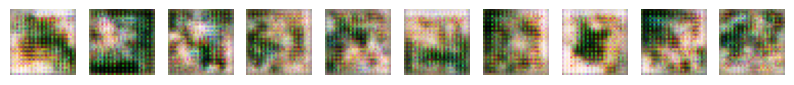

468/468 [==============================] - 27s 35ms/step - d_loss: 0.6433 - g_loss: 0.9643
Epoch 2/50
468/468 [==============================] - 17s 36ms/step - d_loss: 0.6492 - g_loss: 0.8979
Epoch 3/50
468/468 [==============================] - 16s 35ms/step - d_loss: 0.6674 - g_loss: 0.8866
Epoch 4/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6832 - g_loss: 0.8273
Epoch 5/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6685 - g_loss: 0.8271
Epoch 6/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6771 - g_loss: 0.9015
Epoch 7/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6816 - g_loss: 0.8095
Epoch 8/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6729 - g_loss: 0.8415
Epoch 9/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6779 - g_loss: 0.8150
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6777 - g_loss: 0.8

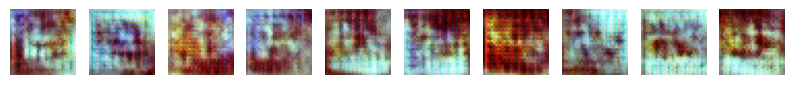

468/468 [==============================] - 14s 31ms/step - d_loss: 0.6782 - g_loss: 0.8428
Epoch 11/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6681 - g_loss: 0.8728
Epoch 12/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6745 - g_loss: 0.8201
Epoch 13/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6778 - g_loss: 0.8212
Epoch 14/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6705 - g_loss: 0.8586
Epoch 15/50
468/468 [==============================] - 15s 33ms/step - d_loss: 0.6830 - g_loss: 0.8083
Epoch 16/50
468/468 [==============================] - 15s 32ms/step - d_loss: 0.6712 - g_loss: 0.9009
Epoch 17/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6729 - g_loss: 0.8766
Epoch 18/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6848 - g_loss: 0.8235
Epoch 19/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6799

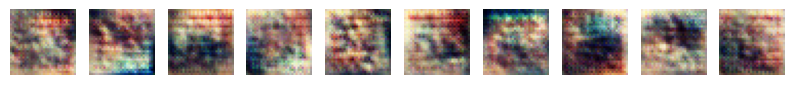

468/468 [==============================] - 15s 31ms/step - d_loss: 0.6705 - g_loss: 0.9024
Epoch 21/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6890 - g_loss: 0.8020
Epoch 22/50
468/468 [==============================] - 16s 33ms/step - d_loss: 0.6781 - g_loss: 0.8301
Epoch 23/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6675 - g_loss: 0.8921
Epoch 24/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6844 - g_loss: 0.8177
Epoch 25/50
468/468 [==============================] - 15s 32ms/step - d_loss: 0.6790 - g_loss: 0.8254
Epoch 26/50
468/468 [==============================] - 15s 32ms/step - d_loss: 0.6733 - g_loss: 0.8334
Epoch 27/50
468/468 [==============================] - 15s 32ms/step - d_loss: 0.6786 - g_loss: 0.8271
Epoch 28/50
468/468 [==============================] - 15s 33ms/step - d_loss: 0.6732 - g_loss: 0.8438
Epoch 29/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6809

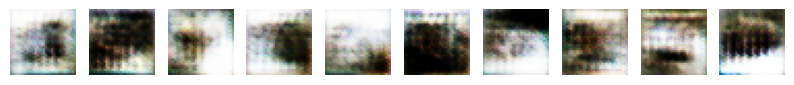

468/468 [==============================] - 16s 34ms/step - d_loss: 0.6725 - g_loss: 0.8421
Epoch 31/50
468/468 [==============================] - 8s 16ms/step - d_loss: 0.6778 - g_loss: 0.8608
Epoch 32/50
468/468 [==============================] - 8s 16ms/step - d_loss: 0.6809 - g_loss: 0.8674
Epoch 33/50
468/468 [==============================] - 8s 16ms/step - d_loss: 0.6864 - g_loss: 0.7565
Epoch 34/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6720 - g_loss: 0.8252
Epoch 35/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6789 - g_loss: 0.9165
Epoch 36/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6791 - g_loss: 0.8341
Epoch 37/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6718 - g_loss: 0.8288
Epoch 38/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6821 - g_loss: 0.8236
Epoch 39/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6824 - 

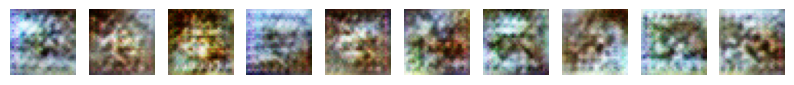

468/468 [==============================] - 19s 41ms/step - d_loss: 0.6905 - g_loss: 0.8013
Epoch 41/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6859 - g_loss: 0.8154
Epoch 42/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6803 - g_loss: 0.7851
Epoch 43/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6822 - g_loss: 0.8108
Epoch 44/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6863 - g_loss: 0.8026
Epoch 45/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6805 - g_loss: 0.8122
Epoch 46/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6795 - g_loss: 0.9109
Epoch 47/50
468/468 [==============================] - 25s 53ms/step - d_loss: 0.6833 - g_loss: 0.7813
Epoch 48/50
468/468 [==============================] - 24s 52ms/step - d_loss: 0.6794 - g_loss: 0.8244
Epoch 49/50
468/468 [==============================] - 17s 36ms/step - d_loss: 0.6790

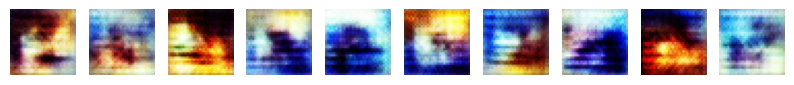

468/468 [==============================] - 16s 35ms/step - d_loss: 0.6675 - g_loss: 0.8577


In [21]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

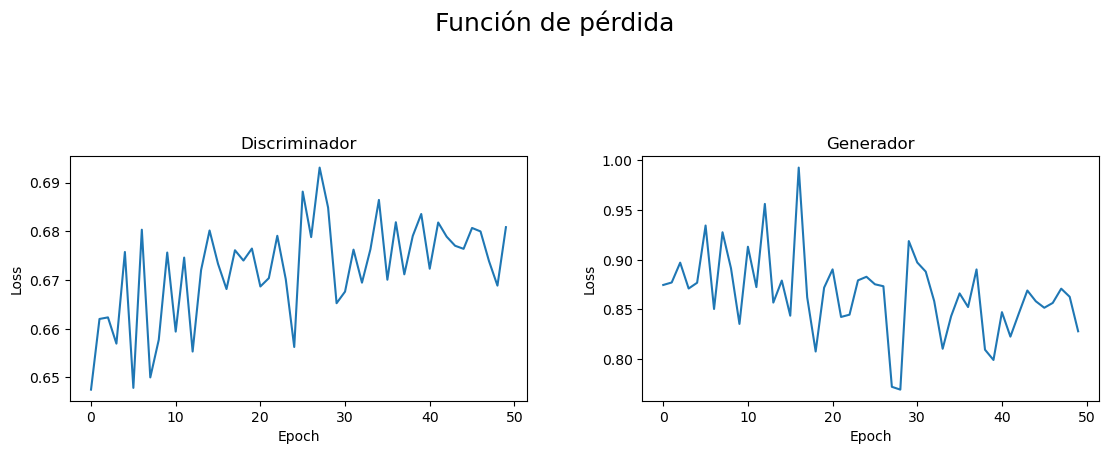

Pérdida discriminador: Min (0.648) Max (0.693) Media (0.672)
Pérdida generador: Min (0.769) Max (0.993) Media (0.865)


In [31]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando la evolución de las pérdidas del discriminador y del generador. \]</mark>

**Teoría Básica:**\
Por teoría sabemos que el generador al principio del proceso va a generar datos sintéticos (imagénes) fáciles de discernir si son verdaderos o falsos por el discriminador. Por tanto, tiene una función de pérdida alta.\
A medida que vaya pasando el tiempo aprende a generar datos sintéticos que son más pareciso a los reales, así que su función de pérdida disminuirá.

El discriminador su función de pérdida es al contrario. Al principio su función de pérdida tendrá valores bajos porque es capaz de diferenciar con facilidad entre datos reales y sintéticos, pero con el tiempo el generador es más hábil por lo que le cuesta más diferenciar y como consecuencia aumenta el valor de la función de pérdida.

**Caso Particular:**\
Para este caso en concreto si hicieramos una regresión lineal, veríamos una recta ascendente y descendente para el discriminador y generador respectivamente.\
Hay oscilación aunque quizá la magnitud de esta es excesiva. He estado mirando si el código escrito no fuera el indicado en los enunciados, pero no es el caso.

El hecho de que oscile es lógico por la definición de función de périda de la GAN que es un mini-max donde los "jugadores" son el discriminador y el generador, lo que uno pierde lo gana el otro.

Algún motivo para justificar que esa oslicación sea tan acusada es que las imagénes tienen muchas características que el modelo ha de aprender.






### Experience replay
<mark>\[Respuesta: Explicar en qué consiste la técnica de *Experience replay* y qué resultados se esperan de su uso. \]</mark>


<mark>\[Respuesta: Explicar qué estrategia de *Experience replay* (de las muchas posibles) se ha implementado en el modelo que hay a continuación. \]</mark>

**Primera Pregunta**

**Definición**\
Experience replay o en castellano experiencia repetida es una técnica usada en reinforcement learning donde se se memoriza y se usan pasadas experiencias.\
Como se usan pasadas experiencias, hay que definir un criterio para seleccionarlas. Se puede optar por un muestreo uniforme que da la misma importancia a todas las experiencias, pero hay experiencia que son más importantes que otras. Por tanto, es mejor buscar criterios que seleccionen las experiencias más importantes.\
En los papers académicos suelen hacer una analogía con el ser humano. Por ejemplo, los niños pequeños cuando aprenden a andar buscan las experiencias que mejor les han ayudado a ello.

**Finalidad**\
La motivación por la que se realiza _experience replay_ es debido al uso de la experiencias previas da estabilidad al proceso de entrenamiento y evita las correlaciones temporales.


**Fuentes**\
<a href="https://arxiv.org/pdf/1906.08387" style="color: white; text-decoration: underline;">Experience Replay Optimization
</a>\
<a href="https://arxiv.org/pdf/2007.06700" style="color: white; text-decoration: underline;">Revisiting Fundamentals of Experience Replay
</a>


**Segunda Pregunta**

**Modelo Implementado**\
Experience Replay aleatoria con buffer de tamaño fijo y reemplazo aleatorio, cuyo nombre en inglés es Random Replay with Random Replacement

El buffer fijo es debido a la sentencia condicional donde su tamaño máximo es 1000.\
El reemplazo aleatorio se realiza en el bucle for. Cuando el buffer esta lleno se sobreescriben algunos de sus elementos al azar 

#### Modelo

In [30]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        # INICIO_RESPUESTA 5/7
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteración
        # Estrategia: Experience Replay con buffer de tamaño fijo y reemplazo aleatorio
        
        #1. Los parametros que vamos a usar
        replay_size = 1000  # size maximo del buffer
        num_replay = 64 # número de imágenes falsas que extraemos del buffer

        #2. Seleccionar las imágenes del generador 
        generated_batch = generated_images[:64]  # Cogemos las primeras num_replay imagenes falas del batch 

        #3. Almacenar en el buffer
        # La sentencia condicional nos asegura que no se supera el almacenamiento maximo del buffer. Si no tuviera puesto esto
        if len(self.experience_replay) < 1000:
            self.experience_replay.extend([img for img in tf.unstack(generated_batch)])
        else:
            for i, img in enumerate(tf.unstack(generated_batch)):
                idx = np.random.randint(0, 1000)
                self.experience_replay[idx] = img
        
                
        #4. Preparar imágenes para el entrenamiento del discriminador
        if len(self.experience_replay) >= num_replay:
            buffer_tensor = tf.stack(self.experience_replay)
            indices = np.random.choice(len(self.experience_replay), size=num_replay, replace=False)
            replay_images = tf.gather(buffer_tensor, indices)
            combined_images = tf.concat([
                generated_images[num_replay:],  # iamgenes nuevas
                replay_images,                  # imagenes falsas  del buffer
                real_images                     # imagenes que son reales
            ], axis=0)

            labels = tf.concat([
                tf.ones((batch_size - num_replay, 1)),  # imagenes falsas nuevas
                tf.ones((num_replay, 1)),               # imagenes falsas del buffer
                tf.zeros((batch_size, 1))               # imagenes que son reales
            ], axis=0)

        # FIN_RESPUESTA 



        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Epoch 1/50
468/468 [==============================] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8494

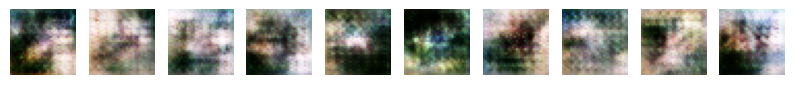

468/468 [==============================] - 8s 17ms/step - d_loss: 0.6695 - g_loss: 0.8494
Epoch 2/50
468/468 [==============================] - 7s 16ms/step - d_loss: 0.6863 - g_loss: 0.7921
Epoch 3/50
468/468 [==============================] - 12s 26ms/step - d_loss: 0.6759 - g_loss: 0.9084
Epoch 4/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6820 - g_loss: 0.8349
Epoch 5/50
468/468 [==============================] - 18s 38ms/step - d_loss: 0.6787 - g_loss: 0.8311
Epoch 6/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6827 - g_loss: 0.8453
Epoch 7/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6769 - g_loss: 0.8238
Epoch 8/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6672 - g_loss: 0.8515
Epoch 9/50
468/468 [==============================] - 17s 37ms/step - d_loss: 0.6883 - g_loss: 0.8579
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.823

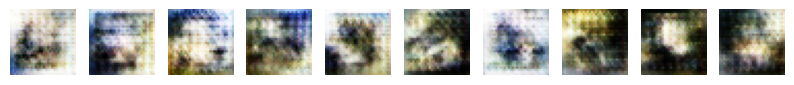

468/468 [==============================] - 20s 44ms/step - d_loss: 0.6763 - g_loss: 0.8239
Epoch 11/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6779 - g_loss: 0.8295
Epoch 12/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6736 - g_loss: 0.8446
Epoch 13/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6787 - g_loss: 0.9050
Epoch 14/50
468/468 [==============================] - 22s 46ms/step - d_loss: 0.6550 - g_loss: 0.9282
Epoch 15/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6577 - g_loss: 0.8838
Epoch 16/50
468/468 [==============================] - 22s 47ms/step - d_loss: 0.6678 - g_loss: 0.8937
Epoch 17/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6511 - g_loss: 0.9448
Epoch 18/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6395 - g_loss: 0.9373
Epoch 19/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6597

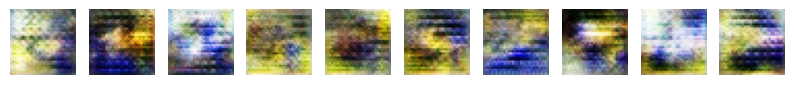

468/468 [==============================] - 22s 47ms/step - d_loss: 0.6427 - g_loss: 0.9810
Epoch 21/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6307 - g_loss: 1.0308
Epoch 22/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6416 - g_loss: 1.0731
Epoch 23/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6226 - g_loss: 0.9781
Epoch 24/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6644 - g_loss: 0.9054
Epoch 25/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6516 - g_loss: 0.9394
Epoch 26/50
468/468 [==============================] - 18s 38ms/step - d_loss: 0.6477 - g_loss: 1.0152
Epoch 27/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6487 - g_loss: 1.0266
Epoch 28/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6161 - g_loss: 1.0348
Epoch 29/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6249

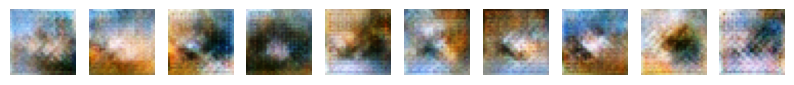

468/468 [==============================] - 18s 39ms/step - d_loss: 0.6306 - g_loss: 0.9338
Epoch 31/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6434 - g_loss: 1.0395
Epoch 32/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6478 - g_loss: 0.9236
Epoch 33/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6460 - g_loss: 0.9536
Epoch 34/50
468/468 [==============================] - 20s 42ms/step - d_loss: 0.6304 - g_loss: 1.0256
Epoch 35/50
468/468 [==============================] - 20s 44ms/step - d_loss: 0.6007 - g_loss: 1.0917
Epoch 36/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.5961 - g_loss: 1.1856
Epoch 37/50
468/468 [==============================] - 22s 47ms/step - d_loss: 0.5935 - g_loss: 1.1154
Epoch 38/50
468/468 [==============================] - 15s 32ms/step - d_loss: 0.5968 - g_loss: 1.2182
Epoch 39/50
468/468 [==============================] - 7s 15ms/step - d_loss: 0.6013 

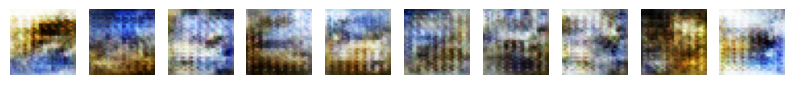

468/468 [==============================] - 7s 16ms/step - d_loss: 0.6208 - g_loss: 1.0407
Epoch 41/50
468/468 [==============================] - 13s 27ms/step - d_loss: 0.5869 - g_loss: 1.1232
Epoch 42/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6054 - g_loss: 1.1296
Epoch 43/50
468/468 [==============================] - 21s 46ms/step - d_loss: 0.5936 - g_loss: 1.2184
Epoch 44/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.5502 - g_loss: 1.2820
Epoch 45/50
468/468 [==============================] - 17s 37ms/step - d_loss: 0.5586 - g_loss: 1.3088
Epoch 46/50
468/468 [==============================] - 27s 58ms/step - d_loss: 0.5894 - g_loss: 1.0860
Epoch 47/50
468/468 [==============================] - 26s 56ms/step - d_loss: 0.5555 - g_loss: 1.3427
Epoch 48/50
468/468 [==============================] - 31s 67ms/step - d_loss: 0.5571 - g_loss: 1.3750
Epoch 49/50
468/468 [==============================] - 31s 66ms/step - d_loss: 0.5350 

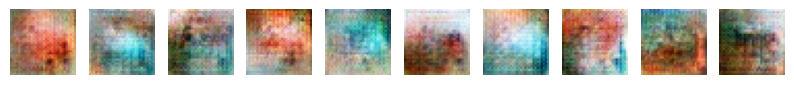

468/468 [==============================] - 32s 69ms/step - d_loss: 0.5679 - g_loss: 1.2897


In [31]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

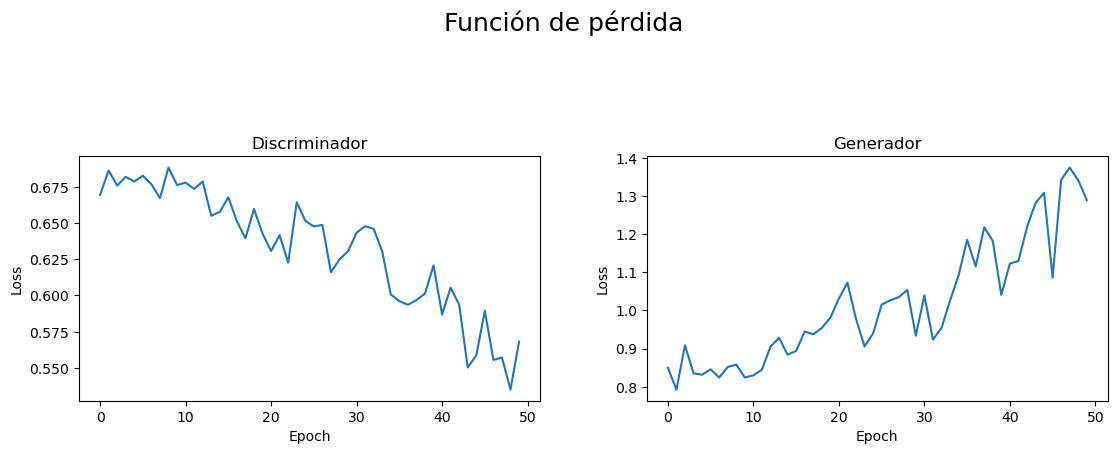

Pérdida discriminador: Min (0.535) Max (0.688) Media (0.633)
Pérdida generador: Min (0.792) Max (1.375) Media (1.016)


In [32]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN sin *Experience replay*. \]</mark>

Hay dos diferencias significativas en las gráficas de las funciones de péridas del discriminador y generador de la GAN con y sin Experience replay.\
Aquí tanto el discriminador como el generador empiezan en valores mucho más alto y bajo respectivamente en su primer epoch. 
Esto es mejor puesto que ayuda a que el generador tenga una etapa más larga de entrenamiento, por lo que conseguirá generar datos sintéticos más parecidos a lo reales.\
Por otro lado, las oscilanes son bastante menores, de hecho es la mayor diferencia respecto al caso anterior. Esto signifca que los valores finales en el último epoch son los que se esperan del modelo.

Esto es importante porque si oscilarán mucho, como el caso sin experience replay, tendríamos dudas de si estamos en una bajada o subida de la oscilación en el último epoch y por tanto podría dar lugar a una mala interpretación.\
Una situación extrema sería la siguiente:\
En esta gráfica el discrinador tiene como Min $0.535$ y Max $0.668$, luego tenemos una diferencia de 0.153. Si cada vez que subiera y bajara tomará esos valores u otros parecidos como $0.535/a$ y $0.668/a$ con $a\in\mathbb{R}$, no habría un tendencia del modelo hacia un valor concreto.\
Así que llegamos a la conclusión que las oscilaciones son positivas porque significa que el modelo esta aprendiendo durante el entrenamiento pero buscamos evitar que sean excesivas.







**Datos importantes Discriminador y Generador**
1. Con Experience Replay\
Pérdida discriminador: Min (0.535) Max (0.688) Media (0.633)\
Pérdida generador: Min (0.792) Max (1.375) Media (1.016)



2. Sin Experience Replay\
Pérdida discriminador: Min (0.648) Max (0.693) Media (0.672)\
Pérdida generador: Min (0.769) Max (0.993) Media (0.865)

### GAN condicional
<mark>\[Respuesta: Explicar en qué consisten las GAN condicionales y qué resultados se esperan de estos modelos en relación al modelo original y al modelo con *Experience replay*. \]</mark>


Una GAN condicional es un tipo de red neuronal donde se imponen condiciones sobre el tipo de imagen que se generan. Les obliga a tener ciertas características que están guardadas en algún lugar como etiquetas o clases.\
Como has etiquetado los datos, estás sesgando al generador a generar datos sintéticos de una manera determinado. Ahora ya no son totalmente aleatorios.\
¿Cuál es el principal beneficio de esto?\
Por ejemplo, en nuestro dataset CIFAR-10 tenemos una imagen del rostro de un caballo. Si damos a nuestro modelo GAN una serie de características del rostro común de un caballo, acabo de generar una serie de etiquetas ha usar por el generador.\
Por tanto, nos permite generar variaciones dentro de la la misma clase (rostro caballo).

**Fuente**\
<a href="https://www.coursera.org/articles/conditional-generative-adversarial-network" style="color: white; text-decoration: underline;">What is a Conditional Generative Adversarial Network
</a>\
<a href="https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/" style="color: white; text-decoration: underline;">How to Develop a Conditional GAN (cGAN)
</a>

#### Discriminador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el discriminador para realizar la discriminación basado en la clase. \]</mark>

**1 Idea Principal**\
El objetivo en una GAN condicional es que el generador aprenda apartir de dos entradas. Un vector ruido aleatorio z y, ahora además, las distintas clases codificadas en one-hot.\
El motivo de porque usar one-hot es debido a que la función train_step() es diseñada para admitir one-hot.\
( Comentar que tuve muchos problemas en esta parte debido a esta función que no código modificable )

Un ejemplo, ilustra bien lo que queremos decir. El dataset CIFAR-10 tiene 10 clases: avión, coche, pájaro, gato, etc. Cada uno se codifica de esta manera\
"gato" → [0 0 0 0 1 0 0 0 0 0].  Esta es la única estructura que admite train_step()

**Nota**\
Intente hacerlo basándome en este github. Personalmente me parece la mejor forma puesto que todo lo que utiliza es con keras y es la finalidad de la prática. Así lo hice y me daba muchos problemas con la función train_step() porque te exige como he comentado antes que sea one-hot. Invertí mucho tiempo en esto la verdad.\
<a href="https://github.com/bnsreenu/python_for_microscopists/blob/master/249_keras_implementation-of_conditional_GAN/249-cifar_conditional_GAN.py" style="color: white; text-decoration: underline;"> Keras implementation of conditional GAN
</a>



**2 Ejecución**


**2.1 Convertir las entradas en vectores**\
Convertimos tanto latent_dim como num_classes a vectores y los alcemanmos en noise_input y label_input respectivamente


**2.2 Concatenar Imágenes entrantes y Mapa de características**\
Se une tanto image_input como label_reshaped usando Concatenate(). El axis=1 nos dice que la unión se hace sobre la segunda posición del tensor, luego tenemos (batch_size, 110).



**2.3 Código Anterior**\
Simplemente el código anteriormente escrito y que volvemos a usar


In [ ]:
# INICIO_RESPUESTA 7/7
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, BatchNormalization, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model


#PARTE NUEVA 
#1 Convertir las entradas en vectores
latent_dim = 100
num_classes = 10

noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))  # ← one-hot


#2 Concatenar Imágenes entrantes y Mapa de características
combined_input = Concatenate(axis=1)([noise_input, label_input])  # (batch_size, 110)


#PARTE ANTIGUA (ya escrita)
# 3. Continuar con el discriminador original (adaptado a 4 canales)
# 1 Grupo
x = Dense(8 * 8 * 128)(combined_input)
x = Reshape((8, 8, 128))(x)
x = BatchNormalization()(x)

# 2 Grupo
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

# 3 Grupo
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

# 4 Grupo
x = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='tanh')(x)

generator = Model([noise_input, label_input], x)
# FIN_RESPUESTA


#### Generador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el generador para generar imágenes de una clase determinada. \]</mark>

La idea es básicamente la misma que con el discriminador, pero aquí en la entrada hay que usar es el vector aleatorio z y concatenarlo con el vector embebido de clases.\
El resultado es (batch_size, 110) con 110 siendo label_input + noise_input.


In [ ]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase 
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

#Parte Nueva
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, BatchNormalization, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model

latent_dim = 100 #tamaño del vector latente 
num_classes = 10 #numero de clases del dataset

label_input = Input(shape=(num_classes,))  # one-hot. Vector con el numero de clases
noise_input = Input(shape=(latent_dim,))   # z. Vector de variable latentes

# 1. Concatenar directamente etiqueta + ruido. El resultado es un tensor de la forma (batch_size, 110). 
combined_input = Concatenate(axis=1)([noise_input, label_input])  # forma: (batch_size, 110)


#PARTE ANTIGUA (ya escrita)
# 3. Pasar por la red generadora original
# 1 Grupo
x = Dense(8 * 8 * 128)(combined_input)
x = Reshape((8, 8, 128))(x)
x = BatchNormalization()(x)

# 2 Grupo
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

# 3 Grupo
x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='tanh')(x)

# Invertimos el orden: primero label_input, luego noise_input
generator = Model([label_input, noise_input], x)
# FIN_RESPUESTA


#### Modelo

In [44]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, real_images[0]], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        self.y_train_enc = y_train_enc

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0
          
          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [45]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10) 
dataset = tf.data.Dataset.from_tensor_slices((all_imgs, all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
468/468 [==============================] - ETA: 0s - d_loss: 0.5333 - g_loss: 1.8327

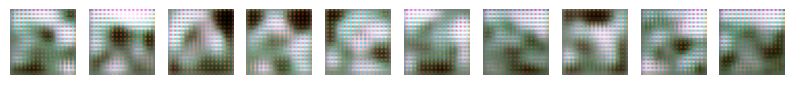

468/468 [==============================] - 23s 47ms/step - d_loss: 0.5333 - g_loss: 1.8327
Epoch 2/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.5630 - g_loss: 1.5743
Epoch 3/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.5859 - g_loss: 1.2024
Epoch 4/50
468/468 [==============================] - 20s 44ms/step - d_loss: 0.6078 - g_loss: 1.0499
Epoch 5/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6509 - g_loss: 0.8870
Epoch 6/50
468/468 [==============================] - 20s 42ms/step - d_loss: 0.6354 - g_loss: 0.9261
Epoch 7/50
468/468 [==============================] - 18s 38ms/step - d_loss: 0.6177 - g_loss: 1.0958
Epoch 8/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6248 - g_loss: 1.0643
Epoch 9/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6302 - g_loss: 1.1179
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6242 - g_loss: 1.0

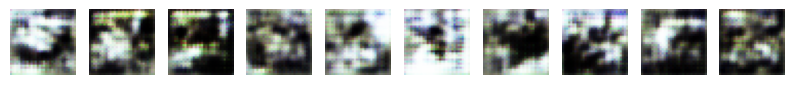

468/468 [==============================] - 20s 42ms/step - d_loss: 0.6241 - g_loss: 1.0425
Epoch 11/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6065 - g_loss: 1.0918
Epoch 12/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6554 - g_loss: 0.9396
Epoch 13/50
468/468 [==============================] - 21s 46ms/step - d_loss: 0.6407 - g_loss: 0.8995
Epoch 14/50
468/468 [==============================] - 21s 46ms/step - d_loss: 0.6645 - g_loss: 0.9039
Epoch 15/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6505 - g_loss: 0.9440
Epoch 16/50
468/468 [==============================] - 21s 45ms/step - d_loss: 0.6614 - g_loss: 0.9324
Epoch 17/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6525 - g_loss: 0.9382
Epoch 18/50
468/468 [==============================] - 20s 42ms/step - d_loss: 0.6391 - g_loss: 1.0662
Epoch 19/50
468/468 [==============================] - 20s 42ms/step - d_loss: 0.6291

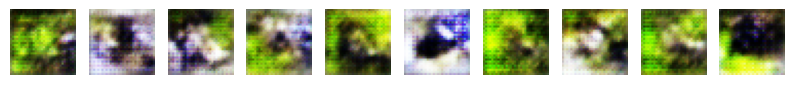

468/468 [==============================] - 20s 43ms/step - d_loss: 0.6449 - g_loss: 1.0363
Epoch 21/50
468/468 [==============================] - 20s 43ms/step - d_loss: 0.6416 - g_loss: 1.0139
Epoch 22/50
468/468 [==============================] - 18s 38ms/step - d_loss: 0.6604 - g_loss: 0.9111
Epoch 23/50
468/468 [==============================] - 17s 37ms/step - d_loss: 0.6690 - g_loss: 0.8926
Epoch 24/50
468/468 [==============================] - 18s 37ms/step - d_loss: 0.6597 - g_loss: 0.8932
Epoch 25/50
468/468 [==============================] - 18s 39ms/step - d_loss: 0.6638 - g_loss: 0.8902
Epoch 26/50
468/468 [==============================] - 19s 41ms/step - d_loss: 0.6665 - g_loss: 0.9055
Epoch 27/50
468/468 [==============================] - 21s 44ms/step - d_loss: 0.6481 - g_loss: 0.9747
Epoch 28/50
468/468 [==============================] - 20s 42ms/step - d_loss: 0.6478 - g_loss: 1.0868
Epoch 29/50
468/468 [==============================] - 18s 38ms/step - d_loss: 0.6405

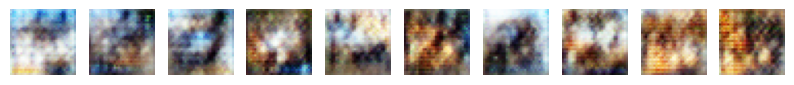

468/468 [==============================] - 22s 46ms/step - d_loss: 0.6671 - g_loss: 0.9919
Epoch 31/50
468/468 [==============================] - 22s 47ms/step - d_loss: 0.6485 - g_loss: 0.9121
Epoch 32/50
468/468 [==============================] - 23s 49ms/step - d_loss: 0.6549 - g_loss: 0.8998
Epoch 33/50
468/468 [==============================] - 27s 58ms/step - d_loss: 0.6356 - g_loss: 0.9914
Epoch 34/50
468/468 [==============================] - 24s 52ms/step - d_loss: 0.6428 - g_loss: 0.9345
Epoch 35/50
468/468 [==============================] - 25s 54ms/step - d_loss: 0.6334 - g_loss: 0.9929
Epoch 36/50
468/468 [==============================] - 27s 58ms/step - d_loss: 0.6384 - g_loss: 1.0193
Epoch 37/50
468/468 [==============================] - 26s 56ms/step - d_loss: 0.6517 - g_loss: 0.9421
Epoch 38/50
468/468 [==============================] - 26s 55ms/step - d_loss: 0.6560 - g_loss: 0.9117
Epoch 39/50
468/468 [==============================] - 26s 55ms/step - d_loss: 0.6481

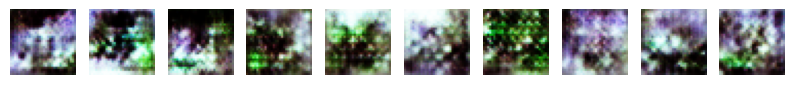

468/468 [==============================] - 28s 59ms/step - d_loss: 0.6477 - g_loss: 0.9225
Epoch 41/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6117 - g_loss: 1.1976
Epoch 42/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6208 - g_loss: 1.0745
Epoch 43/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.5792 - g_loss: 1.2245
Epoch 44/50
468/468 [==============================] - 19s 40ms/step - d_loss: 0.6375 - g_loss: 1.0196
Epoch 45/50
468/468 [==============================] - 23s 50ms/step - d_loss: 0.6281 - g_loss: 1.1244
Epoch 46/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6451 - g_loss: 0.9928
Epoch 47/50
468/468 [==============================] - 10s 22ms/step - d_loss: 0.6423 - g_loss: 0.9029
Epoch 48/50
468/468 [==============================] - 11s 22ms/step - d_loss: 0.6332 - g_loss: 1.0744
Epoch 49/50
468/468 [==============================] - 10s 22ms/step - d_loss: 0.6062

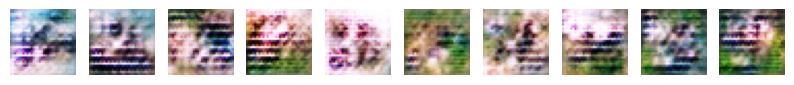

468/468 [==============================] - 11s 22ms/step - d_loss: 0.6145 - g_loss: 1.1199


In [46]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

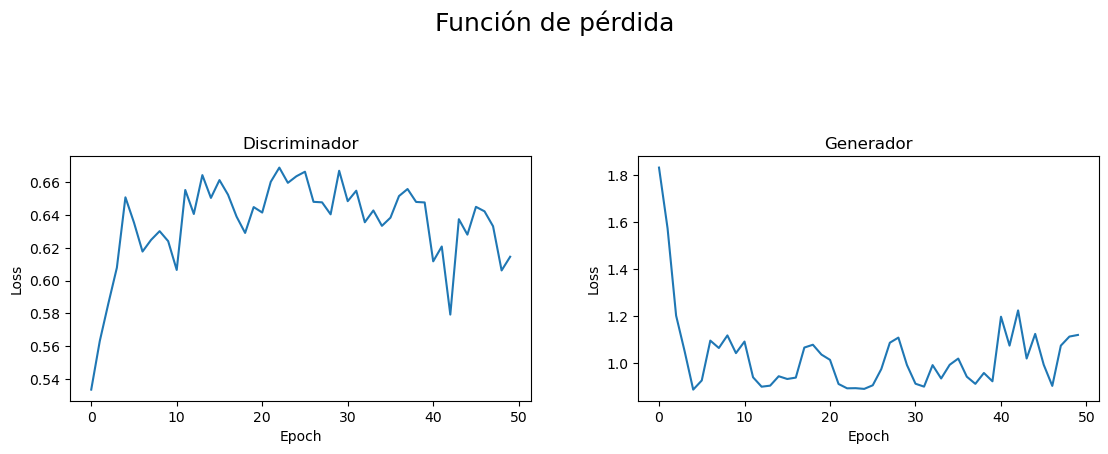

Pérdida discriminador: Min (0.533) Max (0.669) Media (0.635)
Pérdida generador: Min (0.887) Max (1.833) Media (1.032)


In [47]:
plt_loss(history)

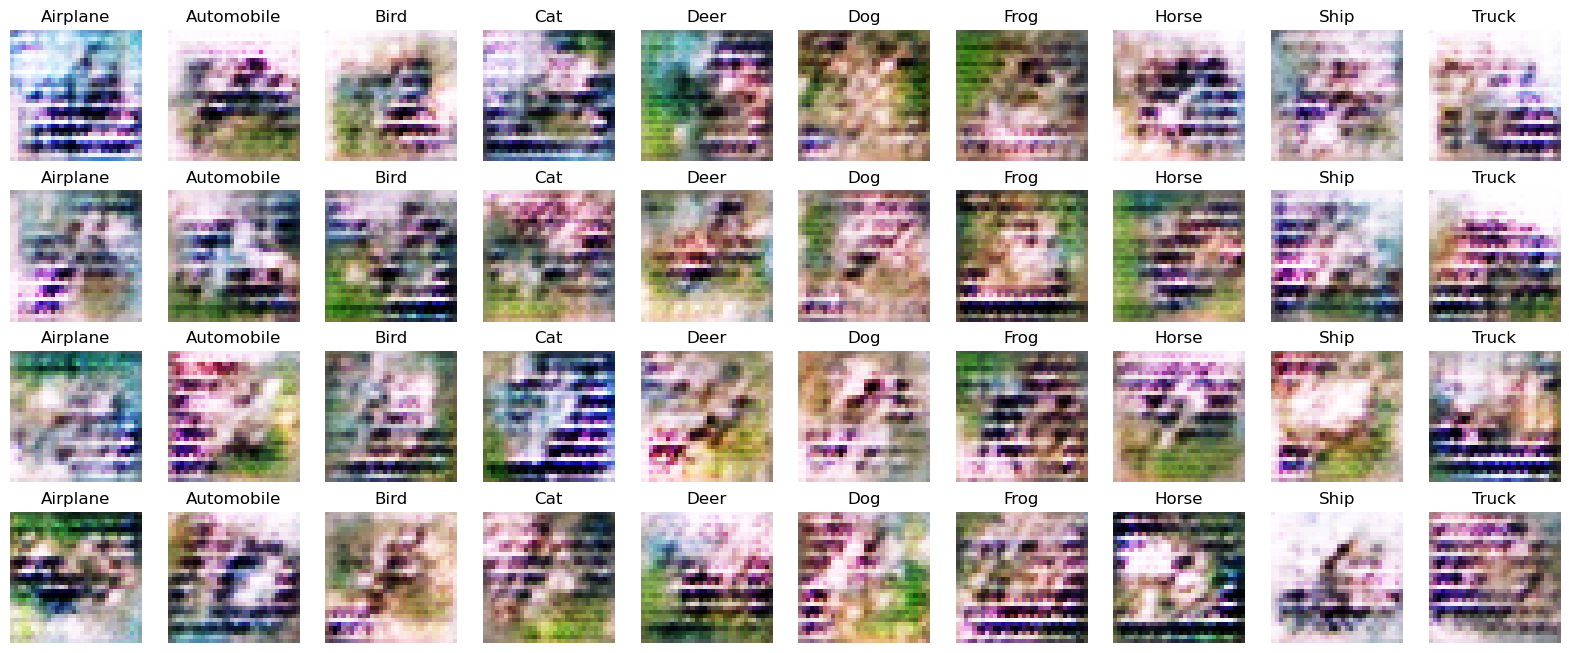

In [48]:
classes_labels = keras.utils.to_categorical([x for x in range(10)] * 4, 10)

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0
# generated_images.numpy()
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN que se ha utilizado como base y la GAN con *Experience replay*. \]</mark>

Hay una diferencia notable de las gráficas de funciones de pérdidas del caso GAN condicional respecto de los otros dos casos. La velocidad con la que aprende el modelo.

Vemos claramente como el discriminador y el generador tienen un comportamiento rectilíneo perfecto en los primeros epochs hasta llegar a casi un máximo y mínimo respectivamente. La interpretación es clara. El generador se le ha dado como entrada un vector aleatorio z junto con una clase, esto provoca el generador este sesgado a generar un tipo de características inducido por la clase. Por tanto, la variabilidad en la salida será pobre provocando que al discriminador le resulte muy fácil saber cuál es el correcto.\
Se llega a un punto de inflexión donde comienza la oscilación, pero esta no aporta una mejora puesto que se pueden poner dos bandas horizontales que engloban la oscilación (si fueran bandas con pendiente sí habría mejoría).

**Conclusión**
Esto es la diferencia principal: GAN condicional vs GAN Base y GAN Experience Replay\
En GAN condicional cuando comienza la oscilación no hay mejoría, en cambio, las otras sí que hay ligera mejoría

Dejo recopiladas las gráficas de las fucniones de pérdidas de los discriminadores y generadores para poder visualizar todas en conjunto más fácilmente.


**Caso GAN Normal**\
Pérdida discriminador: Min (0.648) Max (0.693) Media (0.672)\
Pérdida generador: Min (0.769) Max (0.993) Media (0.865)
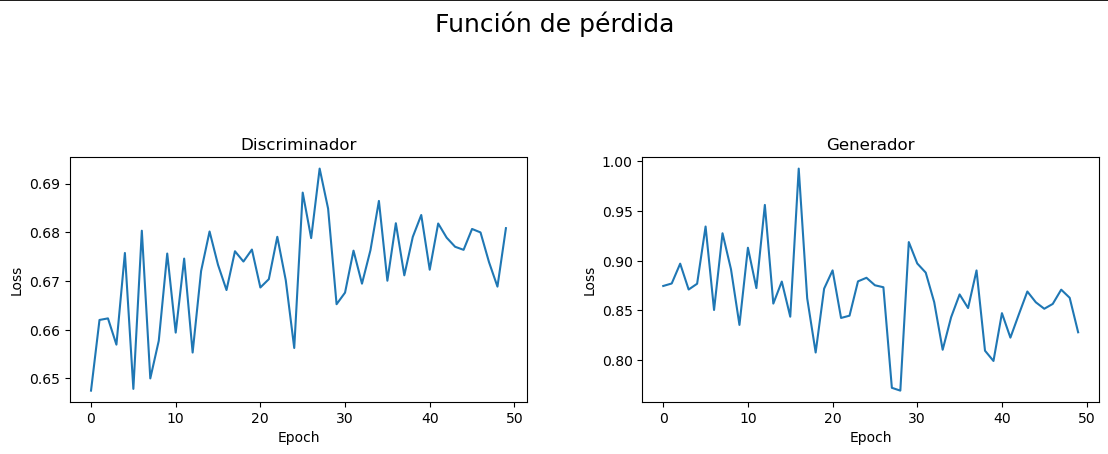

**GAN Experience Replay**\
Pérdida discriminador: Min (0.535) Max (0.688) Media (0.633)\
Pérdida generador: Min (0.792) Max (1.375) Media (1.016)
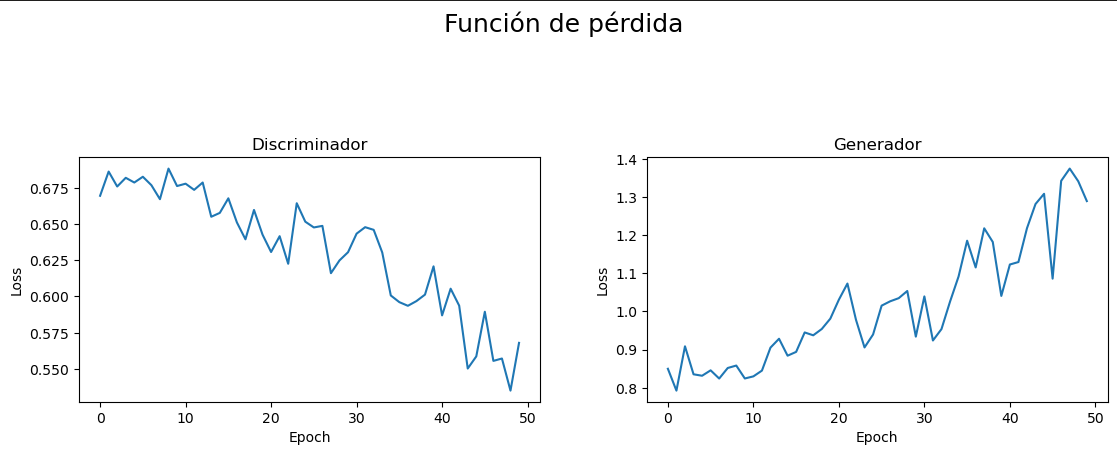

**GAN condicional**\
Pérdida discriminador: Min (0.533) Max (0.669) Media (0.635)\
Pérdida generador: Min (0.887) Max (1.833) Media (1.032)
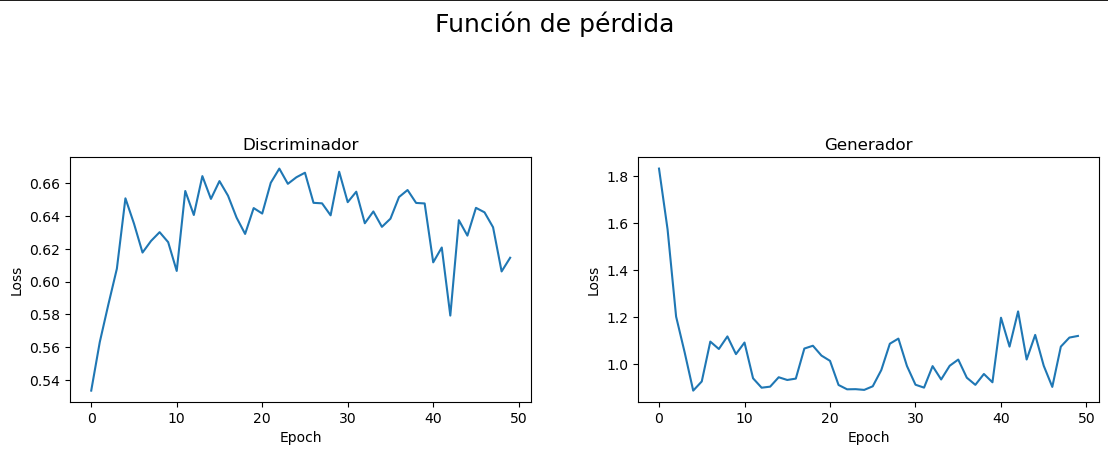

### Conclusiones finales
<mark>\[Respuesta: Resumir el trabajo realizado y las conclusiones principales que se extraen del mismo. \]</mark>

**Parte teórica**\
El trabajo ha consistido en aprender GAN y sus variantes que es un modelo de aprendizaje automático y su estructura, el cual está compuesto por un generador y discriminador que compiten en un juego bipersonal de suma cero. Mientrás mejor lo haga uno peor lo hace el otro. La función usa minimax y en donde intervienen la red del discriminador D(x) y generador G(z).

$$ \min_{\theta} \max_{\phi} \, V(G_{\theta}, D_{\phi}) =
\mathbb{E}_{\mathbf{x} \sim \mathbb{P}_{\text{data}}} [\log D_{\phi}(\mathbf{x})] +
\mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} [\log (1 - D_{\phi}(G_{\theta}(\mathbf{z})))] $$

**GAN Base**\
Las redes neuronales tanto del discriminador y generador han sido creadas para que tengan capas convolucionales2D, LeakyReLU, BatchNormalization y  Dropout.\
Las capas covolucionales son apropiadas puesto que estamos trabjando con el dataset cifar-10. Por tanto, como Conv2D explora relaciones entre píxeles adyacentes mediante pequeños filtros y  permite detectar patrones visuales locales, es el adecuado para ser usado para dicho dataset. Por eso el trabajo es GANs.


**Experience Replay**\
Se nos piden un caso concreto de GAN, este es Experience replay que es una técnica usada en reinforcement learning. Su objetivo principal es dar estabilidad al proceso de entrenamiento y evitar las correlaciones temporales. Como hemos comentado en la práctica, se hace entrenando al modelo con experiencias previas.

**GAN Condicional**\
Pasamos ahora a una GAN donde se les impone condiciones sobre el tipo de imagen que genera el generador. Aquí las entradas no solo el vector aleatorio z como ocurría para el GAN base sino que además tiene un vector con las clases. Por tanto, dos entradas: vector z y vector clases.\
Su objetivo es generar datos sintéticos donde que sean variaciones de una misma clase.

**Interpretación Conjunta de las funciones de pérdida**\
La conclusión más importante al ver las tres gráficas es que las GAN condicionales no tienen oscilación en sus primeros epochs debido a la entrada vector clase incorporada sobre el generador. Además, las oscilaciones son de menor amplitud, lo que sugiere que el modelo ya se ha encontrado cerca de su valor de estabilidad.

### (Opcional) Cycle-GANs 
<mark>\[Respuesta: Buscar información de las *Cycle GANs* y resumir su funcionamiento, haciendo especial énfasis en las novedades que introducen sobre las tipologías vistas en esta práctica . \]</mark>